# Contrail Evolution

The [/trajectory/cocip-contrail endpoint](https://api.contrails.org/openapi#/Trajectory/contrail_cirrus_predictions_contrail_evolution_v0_trajectory_cocip_contrail_post) (added in version 0.8.0) disseminates intermediate contrail evolution data according to the CoCiP model.

Unlike the `/trajectory/cocip` endpoint, which predicts contrail impact per flight waypoint, the `/trajectory/contrail` endpoint returns raw contrail predictions, including optical fields. This endpoint could be used for satellite comparison.

The `/trajectory/cocip-contrail` endpoint supports both single flight and fleet computation. See [Fleet Computation](https://apidocs.contrails.org/notebooks/fleet_mode.html) for getting started with fleet computation.

This notebook demonstrates basic usage of this endpoint.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

In [2]:
# Define credentials
URL = "https://api.contrails.org"
API_KEY = os.environ["CONTRAILS_API_KEY"]  # put in your API key here
HEADERS = {"x-api-key": API_KEY}

In [3]:
# Create synthetic flight

n_waypoints = 200
t0 = "2022-09-21T15:00:00"
t1 = "2022-09-21T19:00:00"

fl = pd.DataFrame()
fl["longitude"] = np.linspace(10, 15, n_waypoints)
fl["latitude"] = np.linspace(35, 65, n_waypoints)
fl["altitude"] = 37000.0
fl["time"] = pd.date_range(t0, t1, periods=n_waypoints).astype(int) // 1_000_000_000

## Post a flight to the `/trajectory/cocip-contrail` endpoint

The response contains a `contrail` field, which holds all of the intermediate contrail predictions. Like all other `/trajectory` response models, the `contrail` data is a list whose items are in one-to-one correspondence with waypoints in the trajectory payload. For example, the 67th element of this contrail list holds contrail evolution data for the 67th waypoint of the flight posted to the endpoint.

In [4]:
payload = fl.to_dict("list") | {"aircraft_type": "A321"}

r = requests.post(f"{URL}/v0/trajectory/cocip-contrail", json=payload, headers=HEADERS)
print(f"HTTP Response Code: {r.status_code} {r.reason}")
r_json = r.json()

HTTP Response Code: 200 OK


In [5]:
# Convert contrail data in response to a pd.DataFrame

contrail = pd.concat([pd.DataFrame(c) for c in r_json["contrail"]])

# The time field has the same format as the request time.
contrail["time"] = pd.to_datetime(contrail["time"], unit="s")
contrail.head(5)

longitude  latitude  altitude                time  tau_cirrus  \
0     13.742    57.458   36906.0 2022-09-21 18:00:00      0.0000   
0     13.858    58.168   36890.0 2022-09-21 18:10:00      0.0008   
0     13.888    58.334   36893.0 2022-09-21 18:10:00      0.0006   
1     13.866    58.226   36870.0 2022-09-21 18:20:00      0.0020   
0     13.917    58.498   36896.0 2022-09-21 18:10:00      0.0000   

   tau_contrail  rf_sw  rf_lw  width  depth  segment_length   n_ice_per_m  \
0        0.0546    0.0  0.453   54.0   57.0             0.0  2.830000e+12   
0        0.0419    0.0  0.468  179.0   76.0         18495.0  2.578000e+12   
0        0.0796    0.0  1.176  146.0   72.0         18361.0  2.657000e+12   
1        0.0185    0.0  0.238  511.0  102.0         18856.0  2.495000e+12   
0        0.1123    0.0  1.787  108.0   68.0         18248.0  2.729000e+12   

      r_ice_vol  
0  3.860000e-07  
0  5.700000e-07  
0  7.930000e-07  
1  6.650000e-07  
0  8.900000e-07

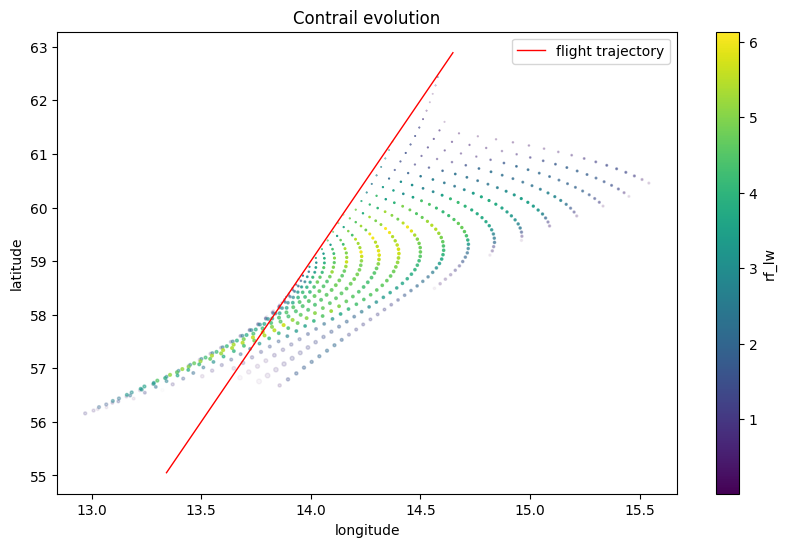

In [6]:
# Visualize the predictions

fig, ax = plt.subplots(figsize=(10, 6))
fl_filt = fl[fl["latitude"].between(55, 63)]
fl_filt.plot(
    x="longitude",
    y="latitude",
    ax=ax,
    lw=1,
    color="red",
    label="flight trajectory",
)

contrail.plot.scatter(
    x="longitude",
    y="latitude",
    c="rf_lw",
    alpha=(10 * contrail["tau_contrail"]).clip(upper=1),
    s=contrail["width"] / 1000,
    ax=ax,
)
ax.set_title("Contrail evolution");

## Post a fleet to the `/trajectory/cocip-contrail` endpoint

We visualize predicted the contrail evolution for a synthetic fleet.

The fleet itself is constructed by perturbing the synthetic flight `fl`.

> **Warning.** The `/trajectory/cocip-contrail` response are often much larger than the responses on other endpoints. This is exacerbated when posting a fleet.

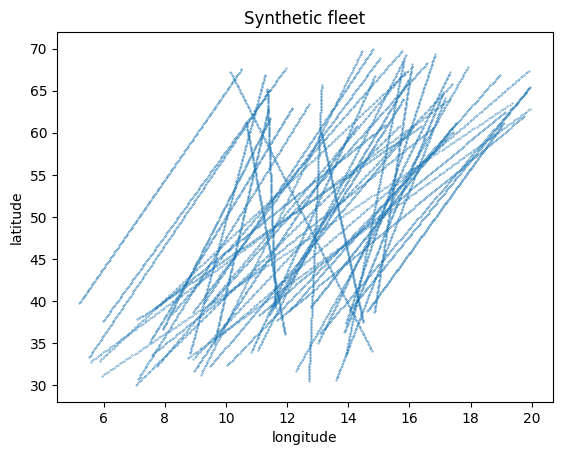

In [7]:
# Construct synthetic fleet with 50 flights

rng = np.random.default_rng(5772156)
fls = []
for fl_id in range(50):
    lon0, lon1, lat0, lat1 = rng.uniform(-5, 5, 4)
    fl_perturb = fl.copy()
    fl_perturb["longitude"] += np.linspace(lon0, lon1, len(fl_perturb))
    fl_perturb["latitude"] += np.linspace(lat0, lat1, len(fl_perturb))
    fl_perturb["flight_id"] = f"{fl_id:2d}"
    fl_perturb["time"] += rng.integers(0, 7200)
    fl_perturb["altitude"] += rng.choice([-2000, 0, 2000])
    fl_perturb["aircraft_type"] = rng.choice(["A320", "B737"])
    fls.append(fl_perturb)
fleet = pd.concat(fls)

# Visualize our synthetic fleet
fleet.plot.scatter("longitude", "latitude", s=0.1, title="Synthetic fleet");

In [8]:
payload = fleet.to_dict("list")

r = requests.post(f"{URL}/v0/trajectory/cocip-contrail", json=payload, headers=HEADERS)
print(f"HTTP Response Code: {r.status_code} {r.reason}")

r_json = r.json()
contrail = pd.concat([pd.DataFrame(c) for c in r_json["contrail"]])
contrail["time"] = pd.to_datetime(contrail["time"], unit="s")

HTTP Response Code: 200 OK


............................................

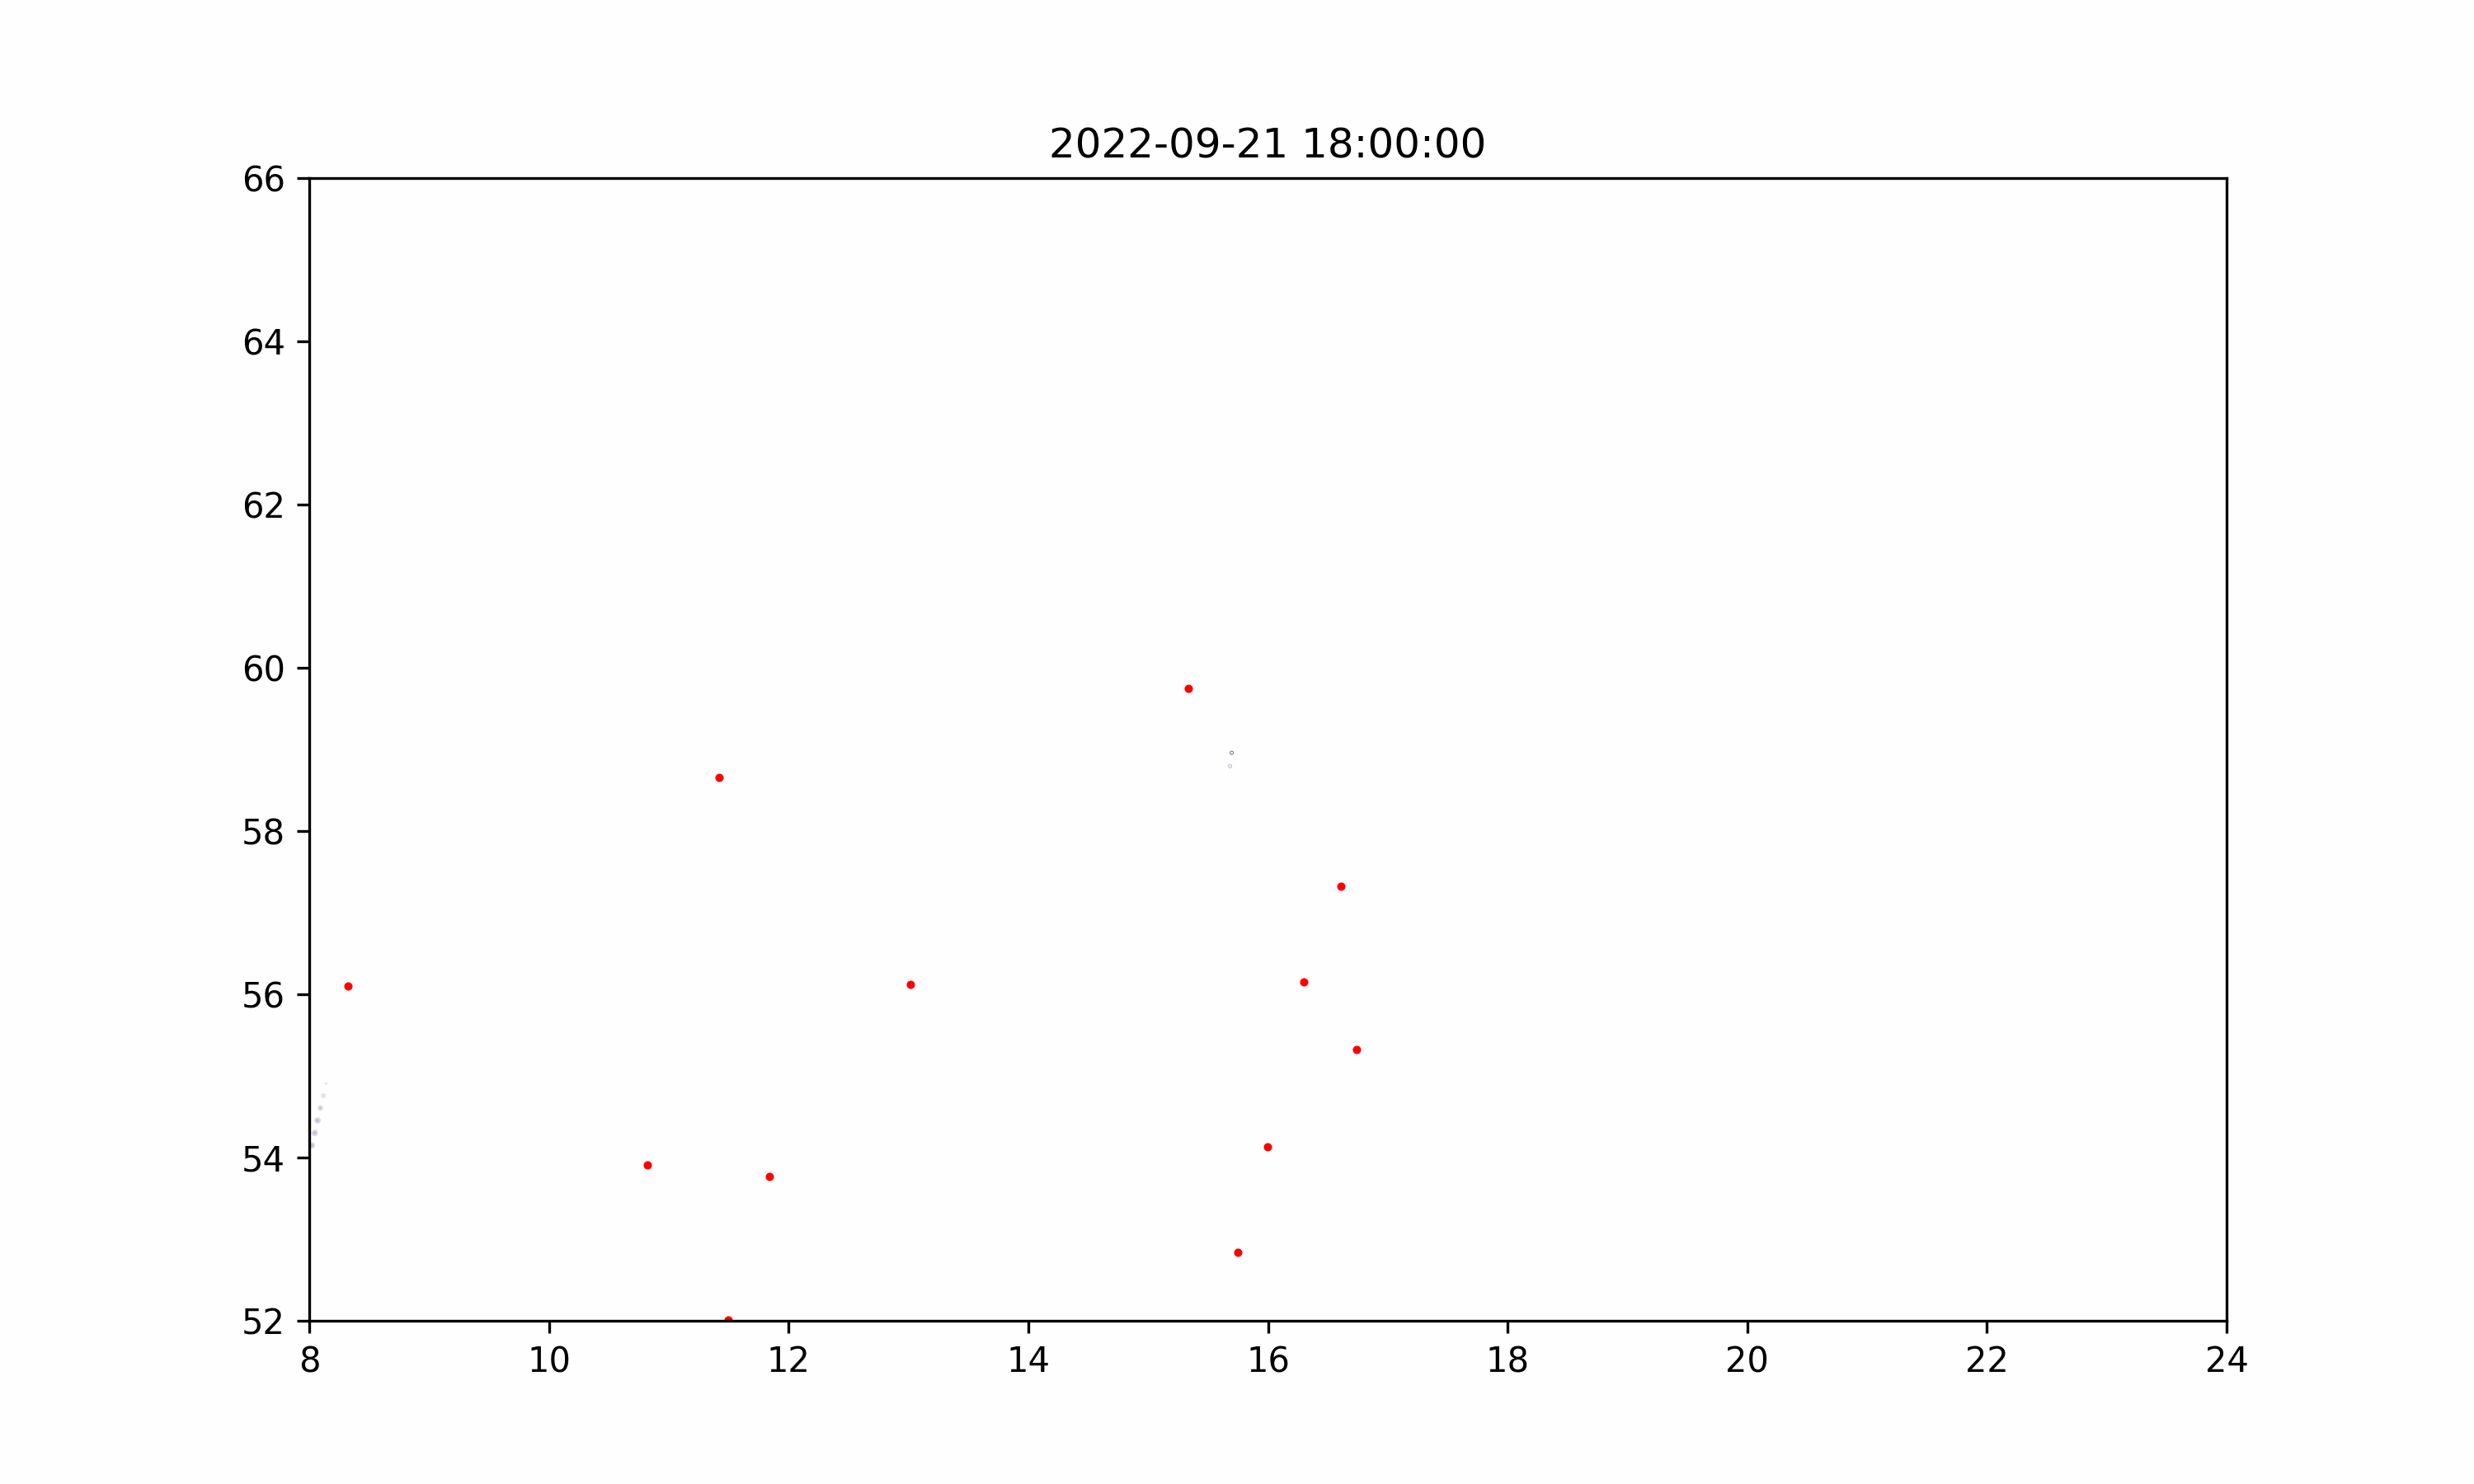

......

......

......

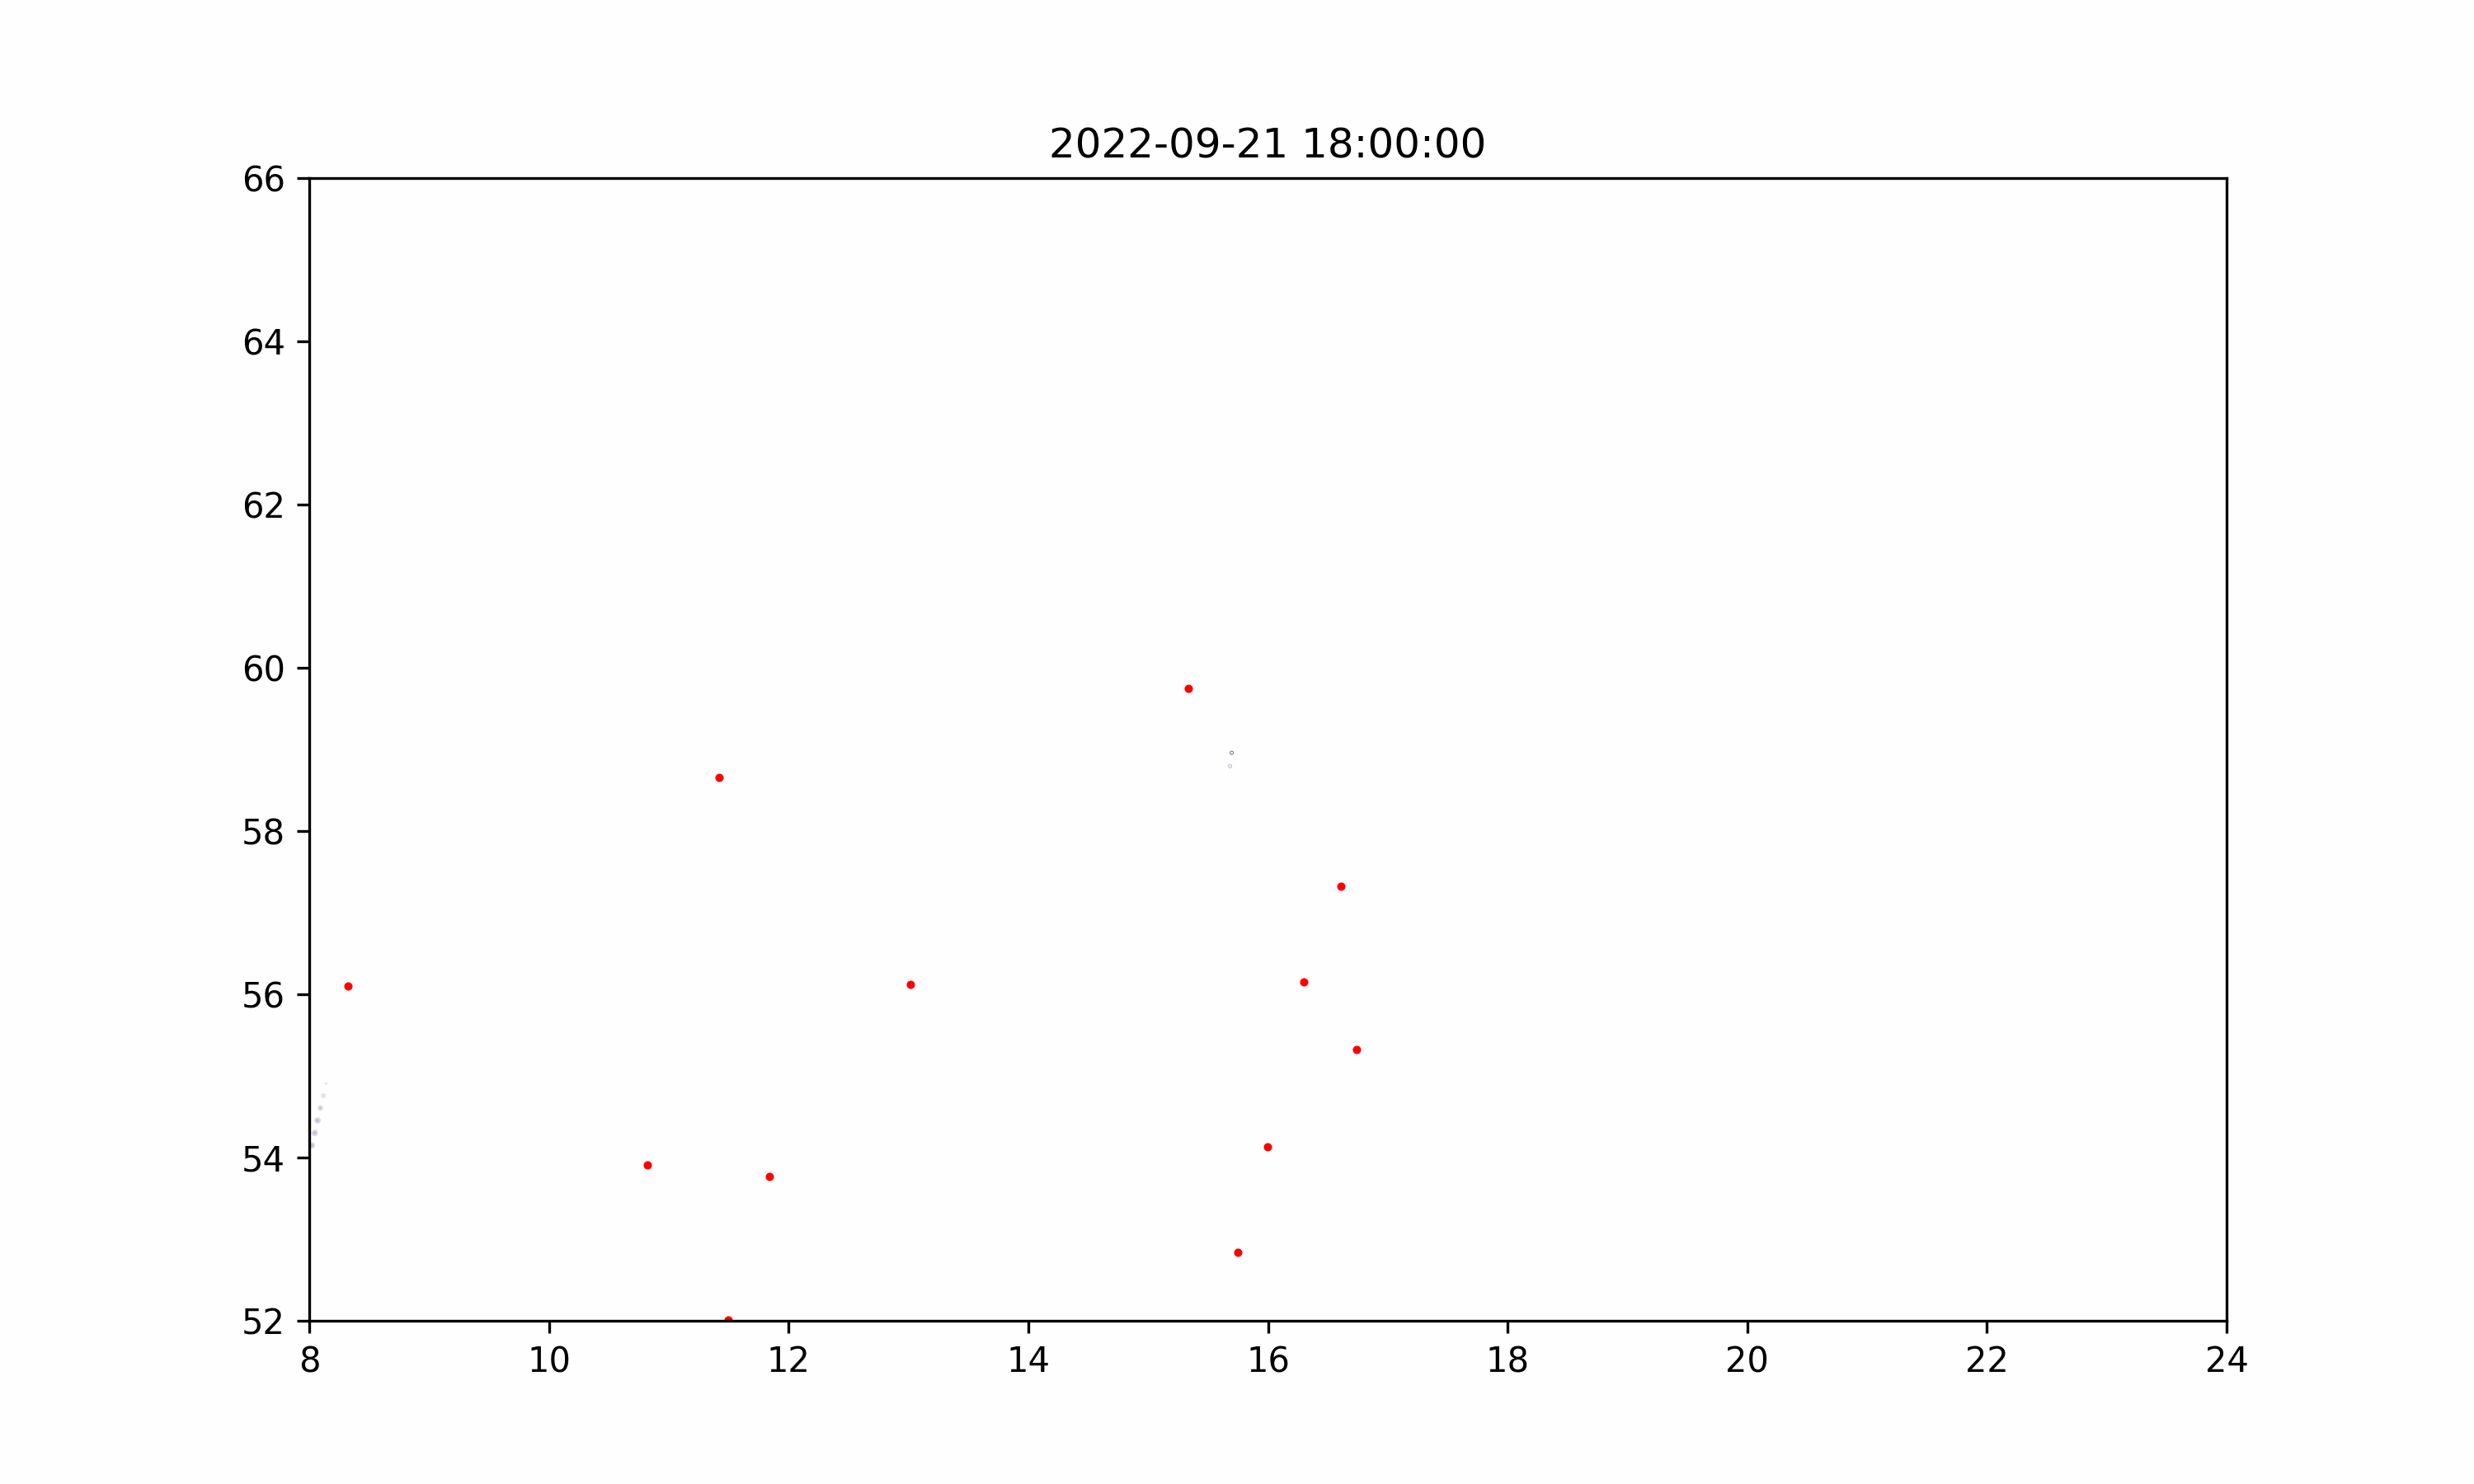

In [9]:
# Visualize the predictions

from matplotlib.animation import FuncAnimation, PillowWriter

fleet = fleet.set_index(pd.to_datetime(fleet["time"], unit="s").dt.floor("1min"))

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(8, 24)
ax.set_ylim(52, 66)

scat1 = ax.scatter([], [], s=2, color="red")
scat2 = ax.scatter([], [], c=[], vmin=0, vmax=20)

filt = (
    contrail["longitude"].between(8, 24)
    & contrail["latitude"].between(52, 66)
    & contrail["time"].between("2022-09-21T18", "2022-09-22T01")
)
contrail_filt = contrail[filt]
frames = contrail_filt.groupby("time")


def animate(frame):
    print(".", end="")  # progress bar
    time, group = frame
    ax.set_title(time)

    try:
        scat1.set_offsets(fleet.loc[time, ["longitude", "latitude"]])
    except KeyError:
        scat1.set_offsets([[None, None]])

    scat2.set_offsets(group[["longitude", "latitude"]])
    scat2.set_alpha((3 * group["tau_contrail"]).clip(upper=1))
    scat2.set_array(group["rf_lw"])
    scat2.set_sizes(group["width"].clip(upper=20000) / 1000)

    return scat1, scat2


plt.close()
ani = FuncAnimation(fig, animate, frames=frames)
ani.save("evo.gif", dpi=300, writer=PillowWriter(fps=2))

# Show the gif
from IPython.display import Image

with open("evo.gif", "rb") as f:
    display(Image(data=f.read(), format="png"))

# Cleanup
os.remove("evo.gif")